In [1]:
import os
import sys
import pandas as pd
from scipy import sparse

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.decomposition import NMF
import seaborn as sns
from matplotlib.colors import LogNorm
import pickle

script_dir = "../"
sys.path.append(os.path.abspath(script_dir))
from file2 import *
from factorize import *
from smallsim_functions4 import *
from misc import *
from sinkhorn import * 

np.random.seed(123)

In [2]:
## load data
dataname = "sla"
k = 6
rate=3

datafile=f"output/fit_sim_{dataname}_fastTopics_k{k}_rate{rate}.pkl"
with open(datafile, "rb") as f:
    fitted = pickle.load(f)
    
X = fitted['X']
Lt = fitted['Ltrue'].T ## k by n
F = fitted['Ftrue']
Strue = fitted['S0']
Sfit = fitted['S']
Cfit = fitted['C']
Ctrue = F @ Lt
Ctrue = (Ctrue @ Ctrue.T) / Lt.shape[1]

## Look at estimation for $C$

In [3]:
Ctrue_bar = Ctrue / Ctrue.sum(axis = 1)[:, None]
Cfit_bar = Cfit / Cfit.sum(axis = 1)[:, None]
err_l1 = np.abs(Cfit_bar - Ctrue_bar).sum(axis = 1)
idx_list = err_l1.argsort()

In [4]:
np.quantile(np.abs(Cfit_bar - Ctrue_bar).sum(axis = 1), 
            q = [0.5, 0.75, 0.9, 1])

array([0.16549683, 0.21941052, 0.28226564, 0.87765227])

In [5]:
np.round((1/F.shape[0]), 7) ## avaerage word probability

0.0001141

worst 100th word: p(w = j) = 0.0; err = 0.4263


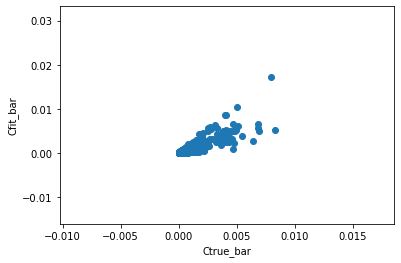

worst 200th word: p(w = j) = 7.5e-06; err = 0.3812


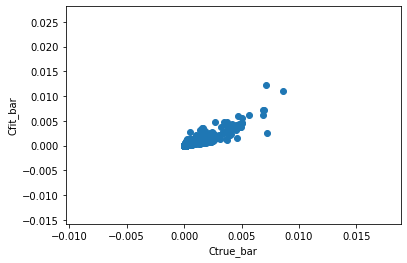

worst 1000th word: p(w = j) = 9.6e-06; err = 0.2736


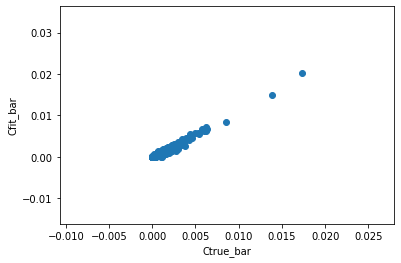

worst 2000th word: p(w = j) = 6.6e-06; err = 0.2254


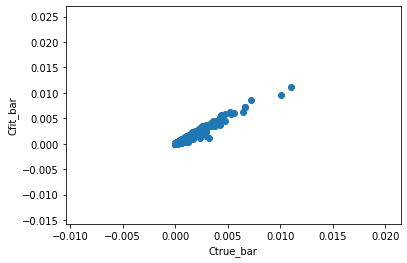

best 100th word: p(w = j) = 0.001857; err = 0.0689


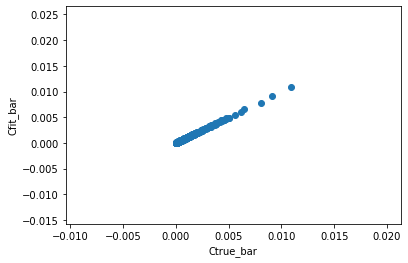

In [6]:
idx = idx_list[-100]
print("worst 100th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(4), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Cfit_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Cfit_bar")
plt.show()


idx = idx_list[-200]
print("worst 200th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(7), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Cfit_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Cfit_bar")
plt.show()

idx = idx_list[-1000]
print("worst 1000th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(7), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Cfit_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Cfit_bar")
plt.show()

idx = idx_list[-2000]
print("worst 2000th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(7), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Cfit_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Cfit_bar")
plt.show()

idx = idx_list[100]
print("best 100th word: p(w = j) = {}; err = {}".format(
    Ctrue[idx,:].sum().round(7), err_l1[idx].round(4)))
plt.scatter(Ctrue_bar[idx,:],Cfit_bar[idx,:])
plt.xlabel("Ctrue_bar")
plt.ylabel("Cfit_bar")
plt.show()



## Compare geometry between $\bar{C}$ and $\hat{\bar{C}}$

true anchor words in true Cbar


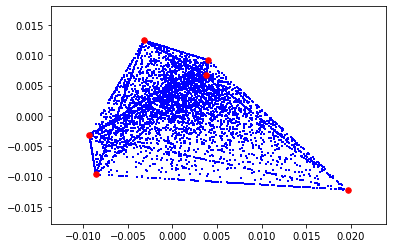

recovered anchor words in true Cbar


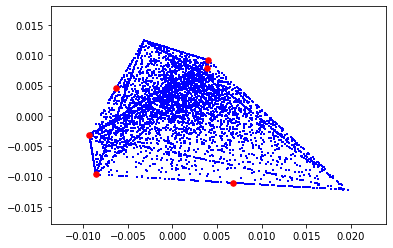

In [7]:
Cbar_proj_true = Cbar_proj(Ctrue)
print("true anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Strue)
print("recovered anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Sfit)

true anchor words in estimated Cbar


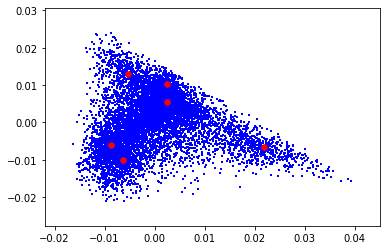

recovered anchor words in estimated Cbar


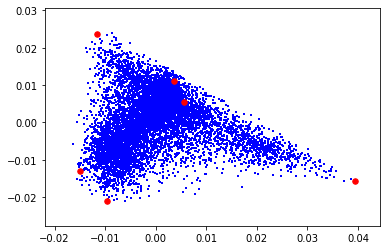

In [8]:
print("true anchor words in estimated Cbar")
Cbar_proj_fit = Cbar_proj(Cfit)
vis_extremal_pca(Cbar_proj_fit, Strue)

print("recovered anchor words in estimated Cbar")
vis_extremal_pca(Cbar_proj_fit, Sfit)

## Try Sinkhorn

In [9]:
%%capture
Xnorm, r, c = sinkhorn(X.toarray(), niter = 20)
C_dn = X2C_svd_large(Xnorm, r = 100)
Sdn_fit, Bdn_fit, Adn_fit, _, _, _, _, C_dn = factorizeC(C_dn, K=k, rectifier='AP', optimizer='activeSet')
Cbar_proj_dn = Cbar_proj(C_dn)

In [10]:
# svd = TruncatedSVD(n_components=10, random_state=42)
# US = svd.fit_transform(Xnorm.T)
# C = US @ US.T - np.diag(np.repeat(1, Xnorm.shape[1]))
# C[C < 0] = 1e-16
# C /= C.sum()

recovered anchor words in true Cbar


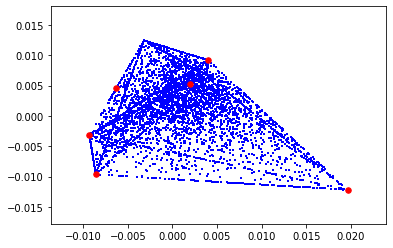

true anchor words in est Cbar


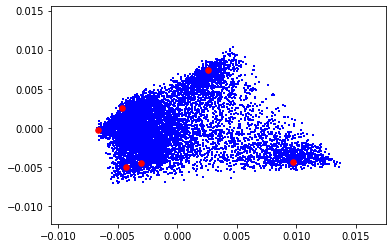

recovered anchor words in est Cbar


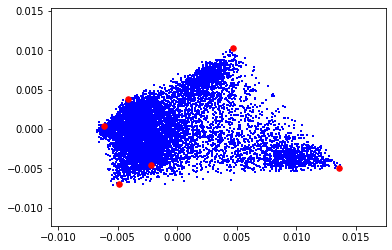

In [11]:
which_dim = [0, 1]
print("recovered anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Sdn_fit, which_dim)
print("true anchor words in est Cbar")
vis_extremal_pca(Cbar_proj_dn, Strue, which_dim)
print("recovered anchor words in est Cbar")
vis_extremal_pca(Cbar_proj_dn, Sdn_fit, which_dim)

## Still MLE is much better!!

Note that I just use the default for convergence criterion. It is even faster than my previous procedure...

In [12]:
%%capture
model = NMF(n_components=k, beta_loss = 'kullback-leibler',
            solver = 'mu', 
            init='random', random_state=0)
W = model.fit_transform(X.T)
H = model.components_

Anmf = (H @ H.T) / X.shape[0]
Cnmf = W @ Anmf @ W.T
Cnmf_bar = Cnmf/Cnmf.sum(axis=1)[:,None]
Cnmf_bar_pj = Cbar_proj(Cnmf)

Snmf, _, _ = findS(Cnmf_bar, k)

recovered anchor words in true Cbar


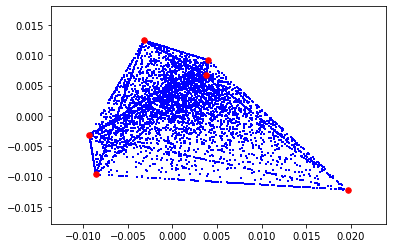

true anchor words in est Cbar


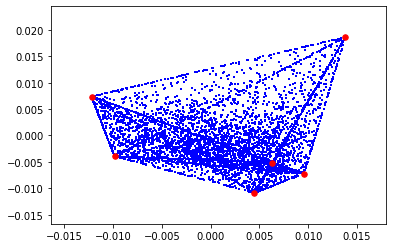

recovered anchor words in est Cbar


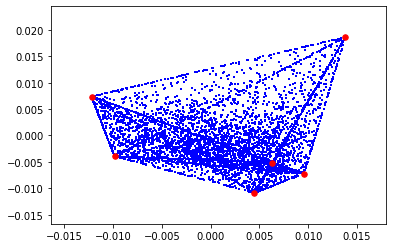

In [13]:
print("recovered anchor words in true Cbar")
vis_extremal_pca(Cbar_proj_true, Snmf, which_dim)
print("true anchor words in est Cbar")
vis_extremal_pca(Cnmf_bar_pj, Strue, which_dim)
print("recovered anchor words in est Cbar")
vis_extremal_pca(Cnmf_bar_pj, Snmf, which_dim)